In [107]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow_addons as tfa
import tensorflow as tf
from IPython import display

In [213]:
train_ds = tf.keras.utils.image_dataset_from_directory(
#   "/home/tony/TO_BE_REMOVED/celeba_data/imgs/",
  "/Users/anthonylaw/Desktop/Endless/GAN-devel/datasets/afhq/train",
  seed=123,
  image_size=(256, 256),
  batch_size=2)

Found 14630 files belonging to 3 classes.


In [57]:
K=len(train_ds.class_names)
print(K)

3


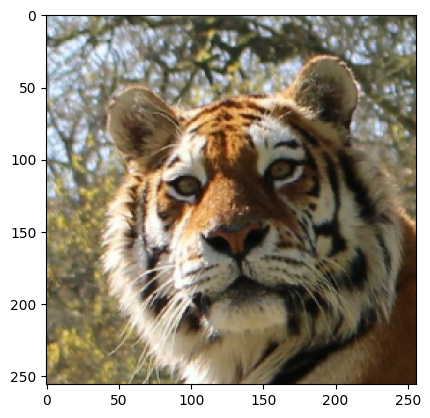

In [226]:
for img, l in train_ds.take(1):
#     print(tf.cast(tf.math.round(img[0]), dtype=tf.int32))
    plt.imshow(tf.cast(tf.math.round(img[0]), dtype=tf.int32))

### Img to Img Generator with style code injection

#### Note:

Implemented with Pre-Act ResBlk

In [232]:
EPSILON = 1e-16

class Generator(Model):
    
    def __init__(self, image_shape_in, image_shape_out, num_channel, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.image_shape_out = image_shape_out
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # Init conv 1x1(perserve pixel info)
        self.in_conv11 = layers.Conv2D(32, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 IN
        self.rb1_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl1 = layers.ReLU()
        self.rb1_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl2 = layers.ReLU()
        self.rb1_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

        # resblk 2 IN
        self.rb2_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl1 = layers.ReLU()
        self.rb2_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl2 = layers.ReLU()
        self.rb2_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        
        # resblk 3 IN
        self.rb3_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb3_rl1 = layers.ReLU()
        self.rb3_conv2d1 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb3_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb3_rl2 = layers.ReLU()
        self.rb3_conv2d2 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # resblk 4 AdaIN
        self.rb4_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb4_rl1 = layers.ReLU()
        self.rb4_conv2d1 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb4_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb4_rl2 = layers.ReLU()
        self.rb4_conv2d2 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
    def call(self, img_in, s_c):
        # conv 1x1
        mu_sc = tf.reduce_mean(s_c)
        sigma_sc = tf.math.reduce_std(s_c)
        
        x = self.in_conv11(img_in)
        
        # resblk 1
        x = self.rb1_conv2d1(self.rb1_rl1(self.rb1_in1(x)))
        x = self.rb1_conv2d2(self.rb1_rl2(self.rb1_in2(x)))
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x = self.rb2_conv2d1(self.rb2_rl1(self.rb2_in1(x)))
        x = self.rb2_conv2d2(self.rb2_rl2(self.rb2_in2(x)))
        
        # resblk 2 downsample
        x = self.ds2(x)

        # resblk 3
        x = self.rb3_conv2d1(self.rb3_rl1(self.rb3_in1(x)))
        x = self.rb3_conv2d2(self.rb3_rl2(self.rb3_in2(x)))

        # resblk 4 AdaIN
        x = self.rb4_conv2d1(self.rb4_rl1(tf.math.add(tf.math.multiply(self.rb4_in1(x), sigma_sc), mu_sc)))
        x = self.rb4_conv2d2(self.rb4_rl2(tf.math.add(tf.math.multiply(self.rb4_in2(x), sigma_sc), mu_sc)))
        
        return x

#### Testing

In [233]:
g_t = Generator((256,256),(256,256),3)

In [234]:
for img, l in train_ds.take(1):
    g_t(img, tf.random.normal((64,)))

In [235]:
g_t.summary()

Model: "generator_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_528 (Conv2D)         multiple                  128       
                                                                 
 instance_normalization_264   multiple                 64        
 (InstanceNormalization)                                         
                                                                 
 re_lu_384 (ReLU)            multiple                  0         
                                                                 
 conv2d_529 (Conv2D)         multiple                  9248      
                                                                 
 instance_normalization_265   multiple                 64        
 (InstanceNormalization)                                         
                                                                 
 re_lu_385 (ReLU)            multiple                 